<a href="https://colab.research.google.com/github/wikipathways/BioThings_Explorer_PFOCR_clustering/blob/main/bte_clustering_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Installation of required packages. 

In [309]:
!pip install numpy pandas requests requests_cache SetSimilaritySearch fisher > pip-log.txt

In [310]:
from IPython.display import display, HTML
display(HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code view"></form>
'''))
#load packages
from urllib.request import urlopen
import requests
import json
import numpy as np
from copy import copy,deepcopy
import pandas as pd
from fisher import pvalue_npy
# Importing reduce for rolling computations
from functools import reduce
import ipywidgets as widgets

## User Inputs

Please complete the form below.

In [305]:
# TRAPI Result URL
trapi_results_url = widgets.Text(
    value='https://arax.ncats.io/api/arax/v1.3/response/7b14f961-9066-41f7-9e3b-d76b2b4a7fac',
    placeholder='Paste here',
    description='',
    disabled=False
)

# Max number of pathway results desired
num_pathways = widgets.IntSlider(
    value=15,
    min=1,
    max=15,
    step=1,
    description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Whether to require figure results include user-specified node IDs from the query
# If true then atleast one of the specified query node ids must be in the result figures
# If false then figures without any of these node ids are also included
require_specified_query_nodes = widgets.Checkbox(
    value=True,
    description='',
    disabled=False,
    indent=False
)
require_specified_query_nodes

box_items = [widgets.VBox([widgets.HBox([widgets.Label('TRAPI Result URL:'),trapi_results_url]),
                        widgets.HBox([widgets.Label('Maxiumum number of desired pathway results:'),num_pathways]),
                        widgets.HBox([widgets.Label('Require specified query nodes in pathway results:'),require_specified_query_nodes])])]
widgets.Box(box_items, layout=widgets.Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='62%'
))

Box(children=(VBox(children=(HBox(children=(Label(value='TRAPI Result URL:'), Text(value='https://arax.ncats.i…

## Load TRAPI Results

Retrieve the JSON response from the provided URL.

In [352]:
with urlopen(trapi_results_url.value) as url:
    trapi_results_json = json.load(url)

# get the TRAPI results and knowledge graph from the json response
trapi_message = trapi_results_json['message']
trapi_results = trapi_message["results"]
trapi_results_df = pd.json_normalize(trapi_results)

# prepare results as a human-readable dataframe
for c in list(trapi_results_df.columns):
    if isinstance(trapi_results_df[c][0], list):
        trapi_results_df[c] = trapi_results_df[c].str[0].str['id']
trapi_results_df

,normalized_score,reasoner_id,score,edge_bindings.e0,edge_bindings.e1,node_bindings.n0,node_bindings.n1,node_bindings.n2
0,100.000000,BTE,2.906806,23a8bbe1078a780814d37f2785fad1ab,133406fa1089f0630ad505ba930f0615,PUBCHEM.COMPOUND:123596,NCBIGene:7422,HP:0002099
1,85.714286,BTE,1.120319,a823bd04f08a5591fba87dc56d52647d,7ee912dbb014b53ed3fcea0e7dc883f8,PUBCHEM.COMPOUND:123596,NCBIGene:841,HP:0002099
2,71.428571,BTE,0.851030,c2323af968047313b3f7d025c3f7c804,1a199ceb3b74961d7b72e222ac9b3172,PUBCHEM.COMPOUND:123596,NCBIGene:4067,HP:0002099
3,57.142857,BTE,0.796666,02217ffa55351b0c3c0a32431158ca27,e2e73e88ecdce75377ff36aae8c52281,PUBCHEM.COMPOUND:123596,NCBIGene:3576,HP:0002099
4,28.571429,BTE,0.000000,6ba3d9ff480ec75e66a38889f0e9c4b2,8b7bd93b93c73afa7122d4b6f11c9258,PUBCHEM.COMPOUND:123596,NCBIGene:142,HP:0002099
5,28.571429,BTE,0.000000,bca736d8e683b35a133bee44f2a75629,fbb3eab04ddeb56570d39d1ee2f82da3,PUBCHEM.COMPOUND:123596,NCBIGene:5156,HP:0002099
6,28.571429,BTE,0.000000,47b528f4619fe13a988467e04b78b536,17a4c659b4a9f1a8bcd164cd17c03db6,PUBCHEM.COMPOUND:123596,NCBIGene:3725,HP:0002099


## Normalize TRAPI Result Dataframe for Enrichment Analysis
  
Unify node identifiers to sources supported by PFOCR pathway figures (NCBIGene, MESH) and prepare CURIE sets for enrichment analysis.

In [353]:
# Using the xrefs in knowledge_graph node attributes we are building dictionaries of 
# result CURIEs and names.
preferred_prefixes = set(["NCBIGene", "MESH"])
curie_to_name = dict()
curie_to_unified_curies = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    curie_to_name[k] = v["name"]
    #first check is k is already what we want
    [prefix, identifier] = k.split(":")
    if prefix in preferred_prefixes:
        curie_to_unified_curies[k] = k
    #else dig into attributes to collect one or more relevant mappings
    else:            
        for a in v["attributes"]:
            if a["attribute_type_id"] == "biolink:xref":
                curies = a["value"]
                unified_curies = set()
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curies.add(curie)
                #assess collected curies
                if len(unified_curies) == 1:
                    curie_to_unified_curies[k] = list(unified_curies)[0]
                elif len(unified_curies) > 1:
                    curie_to_unified_curies[k] = unified_curies
                    
# Append new columns to results df: name and unified_curie
columns_to_lookup = [col for col in trapi_results_df.columns if col.startswith("node_bindings") and col[-2].lower() == 'n'  and col[-1].isdigit()]
new_name_columns = [col.replace("bindings","name") for col in columns_to_lookup]
new_unified_curies_columns = [col.replace("bindings","unified_curies") for col in columns_to_lookup]

# Simple lookup function
def lookup(row, col, lookup_dict):
    return lookup_dict.get(row[col], 'NA')

# Add the new columns per node by applying the lookup function
for i in range(len(columns_to_lookup)):
    trapi_results_df[new_name_columns[i]] = trapi_results_df.apply(lambda row: lookup(row, columns_to_lookup[i], curie_to_name), axis=1)
    trapi_results_df[new_unified_curies_columns[i]] = trapi_results_df.apply(lambda row: lookup(row, columns_to_lookup[i], curie_to_unified_curies), axis=1)

# Append a new columns: result_name and unified_curie_set for pathway analysis
trapi_results_df['result_name'] = trapi_results_df[new_name_columns[0]].str.cat(trapi_results_df[new_name_columns[1:]], sep="_")

def collect_curie_set(row):
    unified_curie_set = set()
    for c in new_unified_curies_columns:
        if isinstance(row[c], set):
            unified_curie_set.update(row[c])
        else:
            unified_curie_set.add(row[c])
    return unified_curie_set
trapi_results_df['unified_curie_set'] = trapi_results_df.apply(collect_curie_set, axis=1)

trapi_results_df

,normalized_score,reasoner_id,score,edge_bindings.e0,edge_bindings.e1,node_bindings.n0,node_bindings.n1,node_bindings.n2,node_name.n0,node_unified_curies.n0,node_name.n1,node_unified_curies.n1,node_name.n2,node_unified_curies.n2,result_name,unified_curie_set
0,100.000000,BTE,2.906806,23a8bbe1078a780814d37f2785fad1ab,133406fa1089f0630ad505ba930f0615,PUBCHEM.COMPOUND:123596,NCBIGene:7422,HP:0002099,Imatinib mesylate,MESH:D000068877,VEGFA,NCBIGene:7422,Asthma,"{MESH:D001249, MESH:D016535}",Imatinib mesylate_VEGFA_Asthma,"{MESH:D001249, MESH:D016535, NCBIGene:7422, ME..."
1,85.714286,BTE,1.120319,a823bd04f08a5591fba87dc56d52647d,7ee912dbb014b53ed3fcea0e7dc883f8,PUBCHEM.COMPOUND:123596,NCBIGene:841,HP:0002099,Imatinib mesylate,MESH:D000068877,CASP8,NCBIGene:841,Asthma,"{MESH:D001249, MESH:D016535}",Imatinib mesylate_CASP8_Asthma,"{MESH:D001249, NCBIGene:841, MESH:D016535, MES..."
2,71.428571,BTE,0.851030,c2323af968047313b3f7d025c3f7c804,1a199ceb3b74961d7b72e222ac9b3172,PUBCHEM.COMPOUND:123596,NCBIGene:4067,HP:0002099,Imatinib mesylate,MESH:D000068877,LYN,NCBIGene:4067,Asthma,"{MESH:D001249, MESH:D016535}",Imatinib mesylate_LYN_Asthma,"{NCBIGene:4067, MESH:D001249, MESH:D016535, ME..."
3,57.142857,BTE,0.796666,02217ffa55351b0c3c0a32431158ca27,e2e73e88ecdce75377ff36aae8c52281,PUBCHEM.COMPOUND:123596,NCBIGene:3576,HP:0002099,Imatinib mesylate,MESH:D000068877,CXCL8,NCBIGene:3576,Asthma,"{MESH:D001249, MESH:D016535}",Imatinib mesylate_CXCL8_Asthma,"{NCBIGene:3576, MESH:D016535, MESH:D001249, ME..."
4,28.571429,BTE,0.000000,6ba3d9ff480ec75e66a38889f0e9c4b2,8b7bd93b93c73afa7122d4b6f11c9258,PUBCHEM.COMPOUND:123596,NCBIGene:142,HP:0002099,Imatinib mesylate,MESH:D000068877,PARP1,NCBIGene:142,Asthma,"{MESH:D001249, MESH:D016535}",Imatinib mesylate_PARP1_Asthma,"{MESH:D001249, MESH:D016535, NCBIGene:142, MES..."
5,28.571429,BTE,0.000000,bca736d8e683b35a133bee44f2a75629,fbb3eab04ddeb56570d39d1ee2f82da3,PUBCHEM.COMPOUND:123596,NCBIGene:5156,HP:0002099,Imatinib mesylate,MESH:D000068877,PDGFRA,NCBIGene:5156,Asthma,"{MESH:D001249, MESH:D016535}",Imatinib mesylate_PDGFRA_Asthma,"{NCBIGene:5156, MESH:D016535, MESH:D001249, ME..."
6,28.571429,BTE,0.000000,47b528f4619fe13a988467e04b78b536,17a4c659b4a9f1a8bcd164cd17c03db6,PUBCHEM.COMPOUND:123596,NCBIGene:3725,HP:0002099,Imatinib mesylate,MESH:D000068877,JUN,NCBIGene:3725,Asthma,"{MESH:D001249, MESH:D016535}",Imatinib mesylate_JUN_Asthma,"{MESH:D001249, NCBIGene:3725, MESH:D016535, ME..."


## Collect CURIEs specified in query

Prepare a set of unified CURIEs from the specified query nodes. This set will be used to restrict or prioritize enrichment results based on the user parameter: `require_specified_query_nodes`.

In [349]:
#get all nodes with ids from the query 
user_specified_ids = set()
for query_node in query_nodes_with_ids:
    user_specified_ids.update(trapi_results_df[f'{query_node}_unified_curie'].tolist())
user_specified_ids

{'MESH:D000068877', 'MESH:D001249'}

## Load PFOCR Pathway Figure Database

Load pathway figure content and metadata for enrichment analysis.

In [273]:
# read in figure metadata for all PFOCR figures
figure_metadata_df = pd.read_csv('https://www.dropbox.com/s/9jorbzpq2k8n5tr/figures_metadata.csv?dl=1', index_col=0)
figure_metadata_df

,figure_url,figure_title
figure_id,,
PMC5732092__cshperspect-CYT-028522_F2.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Interleukin (IL)-17RA/RC signaling pathways
PMC5793760__cshperspect-TGF-022210_F4.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,TGFB signaling pathways
PMC5793761__cshperspect-TGF-031989_F1.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Bone morphogenetic protein (BMP) signaling pat...
PMC5830892__cshperspect-CEL-027961_F2.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,FERM-binding partners of Crumbs3
PMC5830900__cshperspect-TGF-031997_F1.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Role of the TGFB family in mammary gland devel...
...,...,...
PMC2804790__253_2009_2262_Fig1_HTML.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,Ehrlich degradation pathway from amino acid to...
PMC6332787__thnov09p0126g006.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Illustration of the mechanisms underlying LPD ...
PMC5807036__IJO-52-03-0787-g01.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Tumorigenic proteins significantly upregulated...


In [356]:
# read in figure CURIES for all PFOCR figures
figure_curie_df = pd.read_csv('https://www.dropbox.com/s/y3ks74obs3nrjjz/figures_curie.csv?dl=1')
relevant_pfocr_curies = set(figure_curie_df['curie'])
figure_curie_df

,figure_id,curie,category
0,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:5601,gene
1,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:5595,gene
2,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:1051,gene
3,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:10131,gene
4,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:23765,gene
...,...,...,...
1665596,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:1956,gene
1665597,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:4893,gene
1665598,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:2064,gene
1665599,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:3845,gene


## Iterative Enrichment of TRAPI Results Using PFOCR Pathway Figures

We identify the top PFOCR figures by iteratively running Fisher's Exact Test to identify PFOCR figures that are most similar to all the CURIEs from the BTE TRAPI results. To get each figure, we do the following:

1. Run Fisher's Exact Test for the CURIEs from each figure vs. the set of the unique CURIEs found from all the TRAPI results, limiting each set of CURIEs to those found in any PFOCR pathway figure
2. Select the figure with the lowest p-value as a cluster figure
3. Exclude that figure and the CURIEs in it
4. Repeat to get the next cluster figure, continuing until:
    - we run out of enrichement results
    - we repeated steps 1-3 the desired number of times (user input: ```num_pathways```)

In [357]:
def set_union(series):
    return reduce(lambda x, y: x | y, series)

def create_set(series):
    return set(series.tolist())


# TODO: remove cluster_figure_data and its associated DF.
# It's just a temporary thing to show what's happening inside.
cluster_figure_data = []
def get_next_cluster_figures(
    possible_matched_pfocr_curie_count,
    remaining_figures_df,
    remaining_trapi_curie_count,
    required_curies,
    iteration_limit=num_pathways.value, #this is the user-defined parameter for the number of figures
    i=0,
    cluster_figure_ids=[],
):
    remaining_figure_count = len(
        remaining_figures_df
    )

    if (
        i >= iteration_limit
    ) or (
        len(remaining_trapi_curie_count) == 0
    ) or (
        remaining_figure_count == 0
    ):
        return cluster_figure_ids
    
    remaining_figures_df["figure_curie_count"] = remaining_figures_df["curie_set"].map(len)

    remaining_figures_df["figure_curies_in_trapi_results"] = remaining_figures_df["curie_set"].map(
        lambda curie_set: remaining_trapi_curie_count.intersection(
            set(curie_set)
        )
    )

    # number of CURIEs in both TRAPI results and figure
    remaining_figures_df["yes_trapi_results_yes_figure"] = remaining_figures_df[
        "figure_curies_in_trapi_results"
    ].map(len)

    # number of CURIEs in TRAPI results but not in figure
    remaining_figures_df["yes_trapi_results_no_figure"] = (
        len(remaining_trapi_curie_count) -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results but in figure
    remaining_figures_df["no_trapi_results_yes_figure"] = (
        remaining_figures_df["figure_curie_count"] -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results and not in figure,
    # ie., number of unique CURIEs only in other figures
    remaining_figures_df["no_trapi_results_no_figure"] = (
        possible_matched_pfocr_curie_count -
        len(remaining_trapi_curie_count) -
        remaining_figures_df["no_trapi_results_yes_figure"]
    )

    # see https://stackoverflow.com/a/58661068/5354298
    _, _, twosided = pvalue_npy(
        remaining_figures_df["yes_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["yes_trapi_results_no_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_no_figure"].to_numpy('uint'),
    )

    remaining_figures_df["p_value"] = pd.Series(twosided, index=remaining_figures_df.index)
    remaining_figures_df["p_value"].sort_values()
    
    min_df = remaining_figures_df[
        remaining_figures_df["p_value"] == remaining_figures_df["p_value"].min()
    ]
    
    if required_curies:
        # TODO: it might make sense to keep prioritizing the required CURIEs, but
        #       it's not clear whether this is always what we want.
        #       In some cases, we could obscure a different set of results that may
        #       be valuable but not because of the overlap with the required CURIEs.
        curies_to_exclude = set(
            min_df["figure_curies_in_trapi_results"].agg(set_union)
        ) - required_curies
    else:
        curies_to_exclude = set(min_df["figure_curies_in_trapi_results"].agg(set_union))
        
    if len(curies_to_exclude - required_curies) == 0:
        # On this iteration, we failed to match any new CURIE(s), other than
        # possibly just the require CURIEs.
        return cluster_figure_ids
        
    new_cluster_figure_ids = min_df.index.tolist()
    cluster_figure_ids.extend(new_cluster_figure_ids)
    
    next_min_df_score = remaining_figures_df[
        remaining_figures_df["p_value"] > remaining_figures_df["p_value"].min()
    ]["p_value"].min()
    next_min_df = remaining_figures_df[remaining_figures_df["p_value"] == next_min_df_score]
    
    for cluster_figure_id, min_row in min_df.iterrows():
        cluster_figure_data.append({
            "iteration": i,
            "figure_id": cluster_figure_id,
            "p_value": min_row["p_value"],
            "next_best_figure_ids": next_min_df.index.tolist(),
            "next_best_p_value": next_min_df["p_value"].min(),
            "yes_trapi_results_yes_figure": min_row["yes_trapi_results_yes_figure"],
            "yes_trapi_results_no_figure": min_row["yes_trapi_results_no_figure"],
            "no_trapi_results_yes_figure": min_row["no_trapi_results_yes_figure"],
            "no_trapi_results_no_figure": min_row["no_trapi_results_no_figure"],
            "figure_curies_in_trapi_results": min_row["figure_curies_in_trapi_results"],
            "curie_set": min_row["curie_set"],
            "curies_to_exclude": curies_to_exclude,
            "len_curies_to_exclude": len(curies_to_exclude),
            "remaining_figure_count": remaining_figure_count,
            "remaining_trapi_curie_count": len(remaining_trapi_curie_count),
            "cluster_figure_id_count": len(cluster_figure_ids),
        })
    
    # for next iteration, exclude figures we've already added to cluster figures
    next_remaining_figures_df = remaining_figures_df[
        (~remaining_figures_df.index.isin(
            cluster_figure_ids
        ))
    ]
    
    print(
        f'iteration {i:>2}: figures: {len(new_cluster_figure_ids):>2}, CURIEs: {len(curies_to_exclude):>2}'
    )
    
    return get_next_cluster_figures(
        possible_matched_pfocr_curie_count,
        next_remaining_figures_df.reset_index().set_index("figure_id"),
        remaining_trapi_curie_count - curies_to_exclude,
        required_curies,
        iteration_limit,
        i + 1,
        cluster_figure_ids,
    )

possible_matched_figure_curie_df = figure_curie_df[figure_curie_df["curie"].isin(
    list(relevant_pfocr_curies)
)]
possible_matched_pfocr_curie_count = len(set(
    possible_matched_figure_curie_df["curie"].drop_duplicates()
))
print(f'possible_matched_pfocr_curie_count: {possible_matched_pfocr_curie_count}')

possible_matched_figures_df = possible_matched_figure_curie_df[
    ["figure_id", "curie"]
].groupby("figure_id").agg(
    create_set
).rename(columns={
    "curie": "curie_set"
})

possible_matched_figures_df["figure_curies_in_trapi_results_count"] = possible_matched_figures_df[
    "curie_set"
].map(
    lambda curie_set: len(trapi_results_unified_curies.intersection(
        set(curie_set)
    ))
)

overlapping_possible_matched_figures_df = possible_matched_figures_df[
    possible_matched_figures_df["figure_curies_in_trapi_results_count"] > 0
]

# Require that figures have user-specified CURIEs from the query
if require_specified_query_nodes.value:
    required_curies = user_specified_ids
if required_curies:
    overlapping_possible_matched_figures_df = overlapping_possible_matched_figures_df[
        overlapping_possible_matched_figures_df["curie_set"].map(
            # require all of them
            # lambda curie_set: len(curie_set.intersection(required_curies)) == len(required_curies)
            # require at least one of them
            lambda curie_set: len(curie_set.intersection(required_curies)) > 0
        )
    ]

cluster_figure_ids_out = get_next_cluster_figures(
    possible_matched_pfocr_curie_count,
    overlapping_possible_matched_figures_df.reset_index().set_index("figure_id"),
    trapi_results_unified_curies,
    required_curies,
)
print(f'cluster figure count: {len(cluster_figure_ids_out)}')
cluster_figure_df = pd.DataFrame.from_records(cluster_figure_data)
cluster_figure_df

possible_matched_pfocr_curie_count: 30163
cluster figure count: 0


""


# Overview of Results

The figures and tables below summarize the intersections and groupings of your TRAPI results with published pathway figures from the PFOCR daatbase.

### TRAPI results grouped by pathway figures

TODO: Render each figure in iteration order with a table of the results containing intersecting CURIEs (not including the "required" CURIEs) such that users can browse groups of results that have representative figures.

### Matrix of TRAPI results by pathway figures

TODO: build a binary heatmap: rows are concatenated result nodes (from results df in notebook), sorted by original result number (e.g., 0-7), and columns are figures, sorted by iteration order. Need to exclude the query-specified nodes from the overlap logic.

### Matrix of result CURIEs by pathway figures

A binary heatmap of CURIES grouped by pathway figures, sorted by significance (i.e., iteration order).

In [282]:
cluster_figure_df_tall = cluster_figure_df[["figure_id","figure_curies_in_trapi_results"]].explode("figure_curies_in_trapi_results")
#pd.DataFrame([(d, tup.figure_id) for tup in cluster_figure_df.itertuples() for d in tup.figure_curies_in_trapi_results])
cluster_figure_df_tall = cluster_figure_df_tall.rename(columns={"figure_curies_in_trapi_results": "curies"})
cluster_figure_df_tall
cluster_figure_df_tall["value"]=1
df=pd.pivot_table(cluster_figure_df_tall, values="value", index=["curies"], columns="figure_id", fill_value=0)
df=df.sort_values(by=list(df.columns))
df

figure_id,PMC4973429__fphar-07-00237-g0002.jpg,PMC8065335__41392_2021_568_Fig5_HTML.jpg
curies,,
NCBIGene:142,0,1
NCBIGene:3576,0,1
NCBIGene:3725,1,0
MESH:D001249,1,1


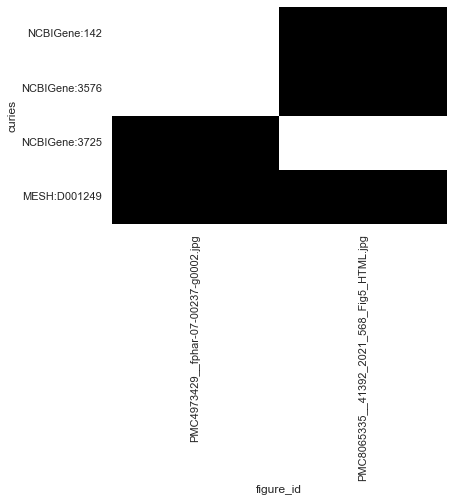

In [278]:
#as heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
sns.set()
sns.heatmap(df, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
plt.show()